In [1]:

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[1], 'GPU')
    print(gpu_devices[1])
    print('Success')



PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Success


In [14]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input 

In [3]:
# Path to your dataset
data_dir = '../Data/bone_marrow_cell_dataset'

# List to store image paths and labels
image_paths = []
labels = []

# Loop through class directories

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):
        for sub_dir_name in os.listdir(class_dir):
            sub_dir_path = os.path.join(class_dir, sub_dir_name)
            
            if os.path.isdir(sub_dir_path):
                for img_name in tqdm(os.listdir(sub_dir_path), desc=f"Processing {class_name}/{sub_dir_name}"):
                    img_path = os.path.join(sub_dir_path, img_name)
                    if os.path.isfile(img_path):
                        image_paths.append(img_path)
                        labels.append(class_name)
            else:
                img_path = os.path.join(class_dir, sub_dir_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_name)
    else:
        img_path = class_dir  # For classes without subdirectories
        if os.path.isfile(img_path):
            image_paths.append(img_path)
            labels.append(class_name)

Processing LYT/13001-14000: 100%|██████████| 1000/1000 [00:00<00:00, 167899.76it/s]


Processing EBO/24001-25000: 100%|██████████| 1000/1000 [00:00<00:00, 175237.27it/s]


In [4]:
# Splitting the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now X_train, y_train, X_val, y_val, X_test, y_test are the organized data for training, validation, and testing
# Combine all labels from train, validation, and test sets
combined_labels = y_train + y_val + y_test

# Print all unique classes
unique_classes = set(combined_labels)
print("Unique classes:", unique_classes)

Unique classes: {'NGB', 'OTH', 'ART', 'PMO', 'BAS', 'FGC', 'KSC', 'MMZ', 'MYB', 'NGS', 'NIF', 'EBO', 'MON', 'PLM', 'EOS', 'LYT', 'PEB', 'ABE', 'BLA', 'LYI', 'HAC'}


In [5]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Calculate the number of classes directly from the labels
num_classes = len(set(combined_labels))

# Convert numerical labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

num_classes


21

In [6]:

# Load VGG-16 model without top (fully connected) layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Create a new model by adding top layers to VGG-16
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


2024-02-13 07:04:25.198695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22118 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                5397      
Total params: 21,142,869
Trainable params: 21,142,869
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Preprocess images using ImageDataGenerator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1. / 255
)


batch_size = 32

# Define a custom generator to load and preprocess images on-the-fly
def custom_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, size=batch_size, replace=False)
        batch_images = []
        batch_labels = []
        for idx in indices:
            img_path = image_paths[idx]
            label = labels[idx]
            try:
                img = load_img(img_path, target_size=(250, 250))  # Resize images to VGG-16 input size
                img_array = img_to_array(img)
                batch_images.append(img_array)
                batch_labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        yield np.array(batch_images), to_categorical(label_encoder.transform(batch_labels), num_classes)

In [17]:
# Create custom generators for training, validation, and test sets
train_generator = custom_generator(X_train, y_train, batch_size)
val_generator = custom_generator(X_val, y_val, batch_size)
test_generator = custom_generator(X_test, y_test, batch_size)

In [10]:

filepath = 'VGG16_weights.hdf5'
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
                  ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)]

In [ ]:
epochs = 10

# Train the model using the custom generator
model.fit(
    custom_generator(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=custom_generator(X_val, y_val, batch_size),
    validation_steps=len(X_val) // batch_size,
    verbose=1,
    callbacks=callbacks_list
)

2024-02-13 07:04:27.410884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2024-02-13 07:04:31.272012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2024-02-13 07:04:42.469420: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3748/3748 [==============================] - 1015s 266ms/step - loss: 2.0607 - accuracy: 0.3617 - val_loss: 1.7022 - val_accuracy: 0.4629

Epoch 00001: val_accuracy improved from -inf to 0.46287, saving model to VGG16_weights.hdf5
Epoch 2/10
3748/3748 [==============================] - 979s 261ms/step - loss: 1.4648 - accuracy: 0.5514 - val_loss: 1.4007 - val_accuracy: 0.5713

Epoch 00002: val_accuracy improved from 0.46287 to 0.57133, saving model to VGG16_weights.hdf5
Epoch 3/10
3748/3748 [==============================] - 956s 255ms/step - loss: 1.3002 - accuracy: 0.5990 - val_loss: 1.2570 - val_accuracy: 0.6075

Epoch 00003: val_accuracy improved from 0.57133 to 0.60753, saving model to VGG16_weights.hdf5
Epoch 4/10
3748/3748 [==============================] - 946s 252ms/step - loss: 1.2299 - accuracy: 0.6196 - val_loss: 1.2019 - val_accuracy: 0.6318

Epoch 00004: val_accuracy improved from 0.60753 to 0.63185, saving model to VGG16_weights.hdf5
Epoch 5/10
3748/3748 [===============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3748/3748 [==============================] - 1077s 287ms/step - loss: 1.6036 - accuracy: 0.4871 - val_loss: 2.4145 - val_accuracy: 0.1717

Epoch 00007: val_accuracy did not improve from 0.64500
Epoch 8/10
  35/3748 [..............................] - ETA: 18:09 - loss: 2.3580 - accuracy: 0.1750

In [12]:
model.save('VGG16_Model.h5')

In [15]:
model_final = load_model('VGG16_weights.hdf5')

In [18]:
# Evaluate the model on the test set using the custom generator
test_loss, test_accuracy = model_final.evaluate(
    test_generator,
    steps=len(X_test) // batch_size,
    verbose=1,
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



803/803 [==============================] - 229s 285ms/step - loss: 1.1689 - accuracy: 0.6379
Test Loss: 1.1689
Test Accuracy: 0.6379


In [19]:

# Determine the size of the test dataset
test_size = len(X_test)

print("Total number of samples in the test dataset:", test_size)


Total number of samples in the test dataset: 25707


In [24]:

from math import ceil
from sklearn.metrics import classification_report

# Determine the size of the test dataset
test_size = len(X_test)

# Calculate the number of steps based on batch size
batch_size = 32  # Adjust according to your generator's batch size
test_steps = ceil(test_size / batch_size)

# Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test generator to obtain predictions batch-wise
for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model_final.predict(x_batch), axis=1))



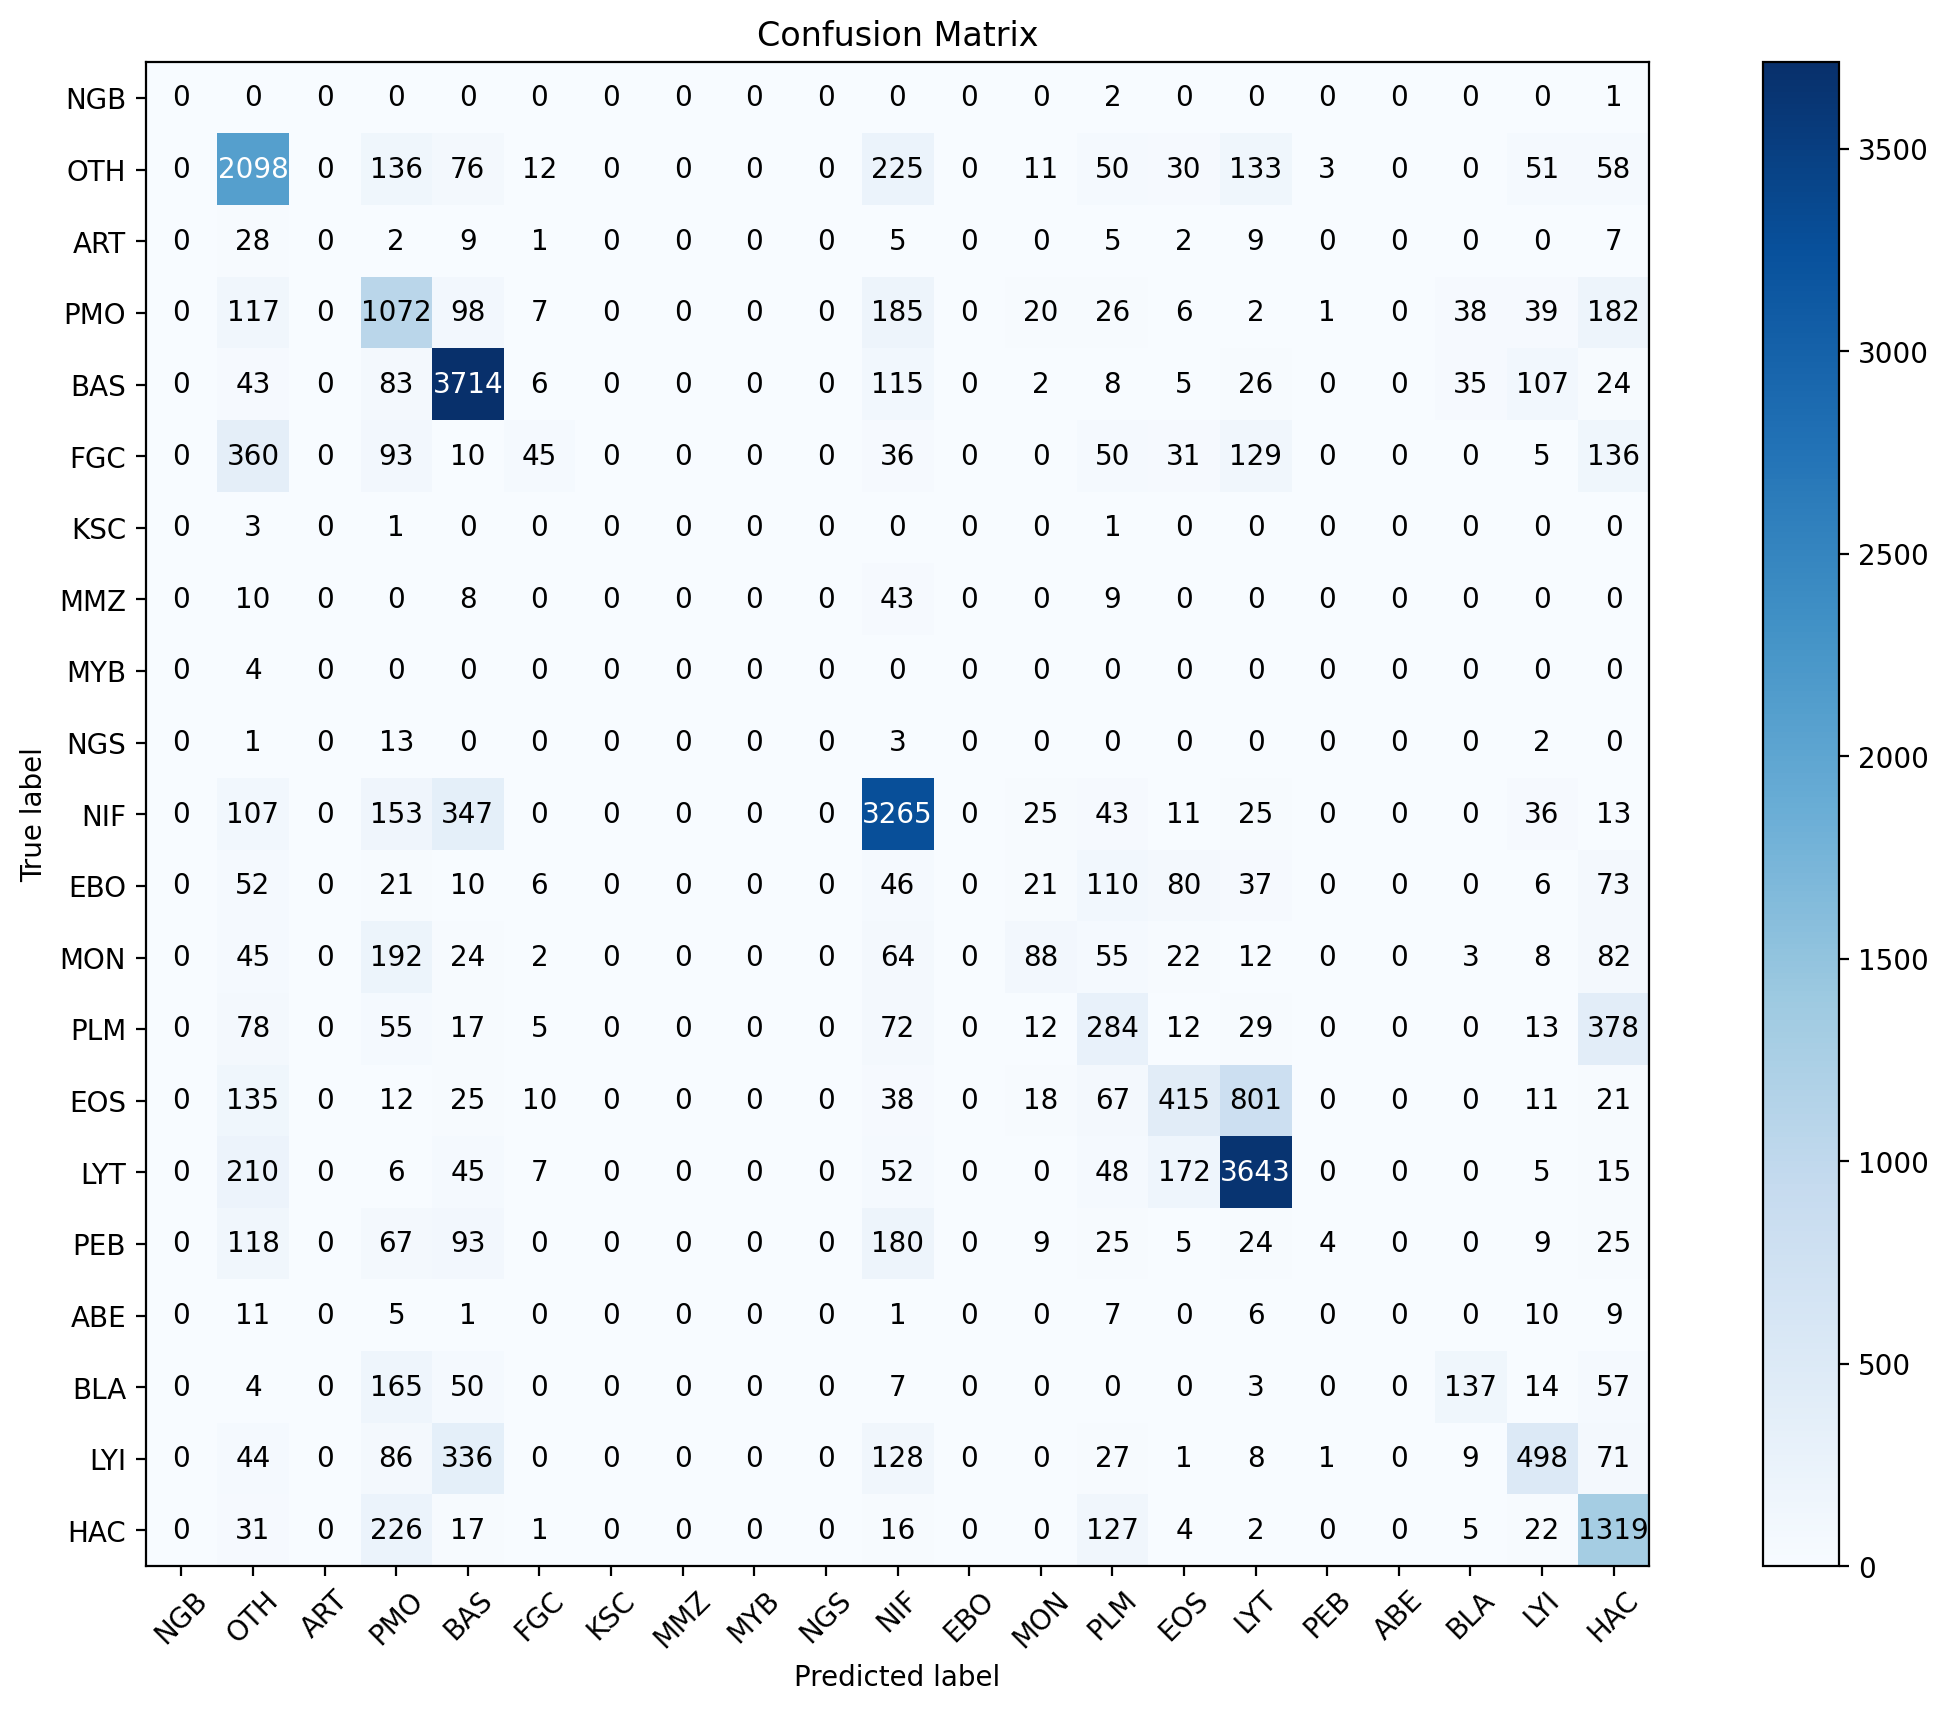

Classification Report:
              precision    recall  f1-score   support

         NGB       0.00      0.00      0.00         3
         OTH       0.60      0.73      0.66      2883
         ART       0.00      0.00      0.00        68
         PMO       0.45      0.60      0.51      1793
         BAS       0.76      0.89      0.82      4168
         FGC       0.44      0.05      0.09       895
         KSC       0.00      0.00      0.00         5
         MMZ       0.00      0.00      0.00        70
         MYB       0.00      0.00      0.00         4
         NGS       0.00      0.00      0.00        19
         NIF       0.73      0.81      0.77      4025
         EBO       0.00      0.00      0.00       462
         MON       0.43      0.15      0.22       597
         PLM       0.30      0.30      0.30       955
         EOS       0.52      0.27      0.35      1553
         LYT       0.75      0.87      0.80      4203
         PEB       0.44      0.01      0.01       559
    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get the list of all possible classes
all_classes = sorted(set(y_true + y_pred + y_train_encoded.tolist()))

# Calculate confusion matrix with all classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_classes)

# Plot confusion matrix
plt.figure(figsize=(11.7, 8.27), dpi=200)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(all_classes))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, unique_classes, rotation=45)
plt.yticks(tick_marks, unique_classes)
plt.savefig('VGG_16.png')
plt.show()

# Calculate classification report
class_report = classification_report(y_true, y_pred,target_names=unique_classes)

# Print classification report
print("Classification Report:")
print(class_report)
